In [1]:
import os
from shutil import copy
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm

In [2]:
# From original dataset
# change file NFI-02306008.png to NFI-02302008.png
# change file NFI-02505009.png to NFI-02505010.png

# Rearrange the data provided
test_image = "02"

re_arranged_signatures_train = "./signatures_dataset_script_split/train"
re_arranged_signatures_test = "./signatures_dataset_script_split/test"

signatures_genuine_dir = "./archive/sample_signature/sample_Signature/genuine"
signatures_forged_dir = "./archive/sample_signature/sample_Signature/forged"

In [3]:
os.mkdir(re_arranged_signatures_train)
os.mkdir(re_arranged_signatures_test)

for signature in os.listdir(signatures_genuine_dir):
    if os.path.isfile(os.path.join(signatures_genuine_dir, signature)):
        try:
            dir_name = signature[9] + signature[10] + signature[11] + "_genuine"
            os.mkdir(os.path.join(re_arranged_signatures_train, dir_name))
            os.mkdir(os.path.join(re_arranged_signatures_test, dir_name))
        except FileExistsError:
            # Directory already exists
            pass
        
        image = signature[7] + signature[8]
        
        if image != test_image:
            copy(os.path.join(signatures_genuine_dir, signature), os.path.join(re_arranged_signatures_train, dir_name))
        else:
            copy(os.path.join(signatures_genuine_dir, signature), os.path.join(re_arranged_signatures_test, dir_name))

for signature in os.listdir(signatures_forged_dir):
    if os.path.isfile(os.path.join(signatures_forged_dir, signature)):
        try:
            dir_name = signature[9] + signature[10] + signature[11] + "_forged"
            os.mkdir(os.path.join(re_arranged_signatures_train, dir_name))
            os.mkdir(os.path.join(re_arranged_signatures_test, dir_name))
        except FileExistsError:
            # Directory already exists
            pass
        
        image = signature[7] + signature[8]
        
        if image != test_image:
            copy(os.path.join(signatures_forged_dir, signature), os.path.join(re_arranged_signatures_train, dir_name))
        else:
            copy(os.path.join(signatures_forged_dir, signature), os.path.join(re_arranged_signatures_test, dir_name))


Image shape: (735, 1460)


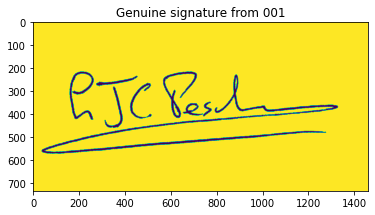

In [4]:
img1 = plt.imread("./signatures_dataset_script_split/train/001_genuine/NFI-00101001.png")
plt.title("Genuine signature from 001")
plt.imshow(img1)
print("Image shape:", img1.shape)

Image shape: (453, 1247)


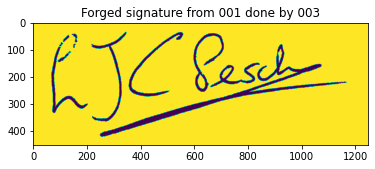

In [5]:
img2 = plt.imread("./signatures_dataset_script_split/train/001_forged/NFI-00301001.png")
plt.title("Forged signature from 001 done by 003")
plt.imshow(img2)
print("Image shape:", img2.shape)

In [6]:
# Pre-processing
SIZE = 224

X_train = []
y_train = []

X_test = []
y_test = []

train_names = []
test_names = []

# Train data
for person in os.listdir('./signatures_dataset_script_split/train'):
    for signature in glob.glob('./signatures_dataset_script_split/train/' + person + '/*.*'):
        
        train_names.append(signature)
        img = cv2.imread(signature)
        # Transform BGR image into GRAY image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize all images to (SIZE, SIZE) images to have the same features
        img = cv2.resize(img, (SIZE, SIZE))
        X_train.append(img)
        
        if person[-1] == 'd':
            y_train.append(np.array(1))
        else:
            y_train.append(np.array(0))
            
X_train = np.array(X_train)
y_train = np.array(y_train)

# Test data
for person in os.listdir('./signatures_dataset_script_split/test'):
    for signature in glob.glob('./signatures_dataset_script_split/test/' + person + '/*.*'):
        
        test_names.append(signature)
        img = cv2.imread(signature)
        # Transform BGR image into GRAY image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize all images to (SIZE, SIZE) images to have the same features
        img = cv2.resize(img, (SIZE, SIZE))
        X_test.append(img)
        
        if person[-1] == 'd':
            y_test.append(np.array(1))
        else:
            y_test.append(np.array(0))
            
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Data set mean: \n{}\n".format(np.mean(X_train)))
print("X_train shape: \n{}\n".format(X_train.shape))
print("y_train shape: \n{}\n".format(y_train.shape))
print("X_test shape: \n{}\n".format(X_test.shape))
print("y_test shape: \n{}\n".format(y_test.shape))


Data set mean: 
243.178987685569

X_train shape: 
(240, 224, 224, 3)

y_train shape: 
(240,)

X_test shape: 
(60, 224, 224, 3)

y_test shape: 
(60,)



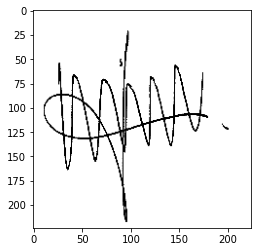

In [22]:
# Exemple of signature pos-processed
plt.imshow(X_train[np.random.randint(0,X_train.shape[0]+1),:])

In [20]:
# Normalize data
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()
y_train_lr = y_train.copy()
y_test_lr = y_test.copy()

# Reshape (x, 224, 224, 3) into (x, 150528)
X_train_lr = X_train_lr.reshape(X_train_lr.shape[0], X_train_lr.shape[1] * X_train_lr.shape[2] * X_train_lr.shape[3])
X_test_lr = X_test_lr.reshape(X_test_lr.shape[0], X_test_lr.shape[1] * X_test_lr.shape[2] * X_test_lr.shape[3])

# Normalize values (before: 0-255) 
X_train_lr = StandardScaler().fit_transform(X_train_lr)
X_test_lr = StandardScaler().fit_transform(X_test_lr)

print("Number signatures train dataset: ", X_train_lr.shape[0])
print("Number signatures test dataset: ", X_test_lr.shape[0])
print("Total number of signatures: ", (X_train_lr.shape[0] + X_test_lr.shape[0]))

Number signatures train dataset:  240
Number signatures test dataset:  60
Total number of signatures:  300


In [9]:
print("Data set mean: \n{}\n".format(np.mean(X_train_lr)))
print("X_train_lr shape: \n{}\n".format(X_train_lr.shape))
print("X_test_lr shape: \n{}\n".format(X_test_lr.shape))
print("y_train_lr shape: \n{}\n".format(y_train_lr.shape))
print("y_test_lr shape: \n{}\n".format(y_test_lr.shape))

Data set mean: 
4.602012900260286e-17

X_train_lr shape: 
(240, 150528)

X_test_lr shape: 
(60, 150528)

y_train_lr shape: 
(240,)

y_test_lr shape: 
(60,)



In [10]:
# Find the best hyper-parameter C. Optimizing for recall perf. metric 
def print_gridsearch_scores(x_train_data,y_train_data):
    c_param_range = [0.01,0.1,1,10]

    clf = GridSearchCV(LogisticRegression(), {"C": c_param_range}, cv=5, scoring='recall')
    clf.fit(x_train_data,y_train_data)

    print("Best parameters found on CV(dev) set:")
    print()
    print(clf.best_params_)

    print("K-fold Score (Recall) on CV (dev) set:")
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    #Visualization of the K-fold Recall results for different hyper parameters C
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    return clf.best_params_["C"]

In [11]:
# Get the best C for provided dataset
best_c = print_gridsearch_scores(X_train_lr, y_train_lr)

Best parameters found on CV(dev) set:

{'C': 0.01}
K-fold Score (Recall) on CV (dev) set:
0.442 (+/-0.336) for {'C': 0.01}
0.442 (+/-0.336) for {'C': 0.1}
0.433 (+/-0.340) for {'C': 1}
0.408 (+/-0.213) for {'C': 10}


In [12]:
# Use the best C to train LogReg model
lr = LogisticRegression(C=best_c)
lr.fit(X_train_lr, y_train_lr)
y_pred = lr.predict(X_test_lr)

print('Accuracy: ', lr.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))

# Make tests with different otptimization algorithms
# Optimizer --> lbfgs - Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm
# Cost function --> L2 norm
# https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions

Accuracy:  0.8166666666666667
Precision: 0.8170189098998888
Recall: 0.8166666666666667
Fscore: 0.8166157265907197


In [13]:
def dataset3Params(X, y, Xval, yval,vals,kernel):
    """
    dataset3Params returns the optimal C and gamma(1/sigma) based on a cross-validation set.
    """
    acc = 0
    best_C=0
    best_gamma=0
    for i in vals:
        C= i
        for j in vals:
            gamma = 1/j
            classifier = svm.SVC(kernel=kernel,C=C,gamma=gamma)
            classifier.fit(X,y)
            prediction = classifier.predict(Xval)
            score = classifier.score(Xval,yval)
            if score>acc:
                acc =score
                best_C =C
                best_gamma=gamma
    return best_C, best_gamma

In [14]:
# Linear SVM
vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_C, best_gamma = dataset3Params(X_train_lr, y_train_lr.ravel(), X_test_lr, y_test_lr.ravel(),vals,'linear')

#What are the best C and sigma ?
print("Best C: {}\nBest gamma: {}\nBest sigma: {}".format(best_C, best_gamma, 1/best_gamma))

classifier = svm.SVC(kernel="linear",C=best_C,gamma=best_gamma)
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Best C: 0.01
Best gamma: 100.0
Best sigma: 0.01
Accuracy:  0.8
Precision: 0.8013392857142857
Recall: 0.8
Fscore: 0.7997775305895439


In [15]:
# RBF SVM
vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_C, best_gamma = dataset3Params(X_train_lr, y_train_lr.ravel(), X_test_lr, y_test_lr.ravel(),vals,'rbf')

#What are the best C and sigma ?
print("Best C: {}\nBest gamma: {}\nBest sigma: {}".format(best_C, best_gamma, 1/best_gamma))

classifier = svm.SVC(kernel="rbf",C=best_C,gamma=best_gamma)
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Best C: 0.01
Best gamma: 100.0
Best sigma: 0.01
Accuracy:  0.5
Precision: 0.25
Recall: 0.5
Fscore: 0.3333333333333333


/home/dvc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# sigmoid SVM
vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_C, best_gamma = dataset3Params(X_train_lr, y_train_lr.ravel(), X_test_lr, y_test_lr.ravel(),vals,'sigmoid')

#What are the best C and sigma ?
print("Best C: {}\nBest gamma: {}\nBest sigma: {}".format(best_C, best_gamma, 1/best_gamma))


classifier = svm.SVC(kernel="sigmoid",C=best_C,gamma=best_gamma)
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Best C: 1
Best gamma: 100.0
Best sigma: 0.01
Accuracy:  0.5666666666666667
Precision: 0.5678733031674208
Recall: 0.5666666666666667
Fscore: 0.5647321428571428


In [17]:
# poly
vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_C, best_gamma = dataset3Params(X_train_lr, y_train_lr.ravel(), X_test_lr, y_test_lr.ravel(),vals,'poly')

#What are the best C and sigma ?
print("Best C: {}\nBest gamma: {}\nBest sigma: {}".format(best_C, best_gamma, 1/best_gamma))


classifier = svm.SVC(kernel="poly",C=best_C,gamma=best_gamma)
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))


Best C: 0.01
Best gamma: 100.0
Best sigma: 0.01
Accuracy:  0.6666666666666666
Precision: 0.6696832579185521
Recall: 0.6666666666666666
Fscore: 0.6651785714285714


In [18]:
# Neural network models (supervised)
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(15,),batch_size=64,verbose=True)
classifier.fit(X_train_lr, y_train_lr)
y_pred = classifier.predict(X_test_lr)

print('Accuracy: ', classifier.score(X_test_lr, y_test_lr))
values = precision_recall_fscore_support(y_test_lr, y_pred, average='macro')
print("Precision: {}\nRecall: {}\nFscore: {}".format(values[0], values[1], values[2]))

Accuracy:  0.7833333333333333
Precision: 0.799647473560517
Recall: 0.7833333333333333
Fscore: 0.7803435651929034
